In [32]:
import pandas as pd
import numpy as np
from scipy.special import logsumexp
from sklearn.model_selection import GroupShuffleSplit 
from models import utils
from models import mace, latent_annotator_clustering
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score

In [33]:
train_df = pd.read_csv('./data/sap2019risk_mTurkExperiment.csv',delimiter=',', encoding='latin-1')
train_df = train_df.dropna(subset=['offensive2anyoneYN'])
annotator_df = train_df[['WorkerIdHashed','annotatorPolitics','annotatorRace','annotatorAge','annotatorGender']].drop_duplicates().dropna()


In [34]:
#drop all the rows with any  "na" values in annotator_df
annotator_df = annotator_df[annotator_df.annotatorPolitics != "na"]
annotator_df = annotator_df[annotator_df.annotatorRace != "na"]
annotator_df = annotator_df[annotator_df.annotatorAge != "na"]
annotator_df = annotator_df[annotator_df.annotatorGender != "na"]


In [35]:
len(train_df), len(annotator_df)

(11706, 372)

In [36]:
len(annotator_df["WorkerIdHashed"].unique().tolist()), len(annotator_df["WorkerIdHashed"].tolist())

(321, 372)

In [37]:
train_df

,annotatorAge,annotatorGender,annotatorMinority,annotatorPolitics,annotatorRace,intentYN,offensive2anyoneYN,offensive2youYN,dialectIsWrong,raceIsWrong,WorkerIdHashed,tweet,dialect,condition,username,davidson_label,founta_label
0,31,man,{},liberal,white,0.000000,0.0,0.0,NaN,NaN,ab647dbde8ff4aab46c8cec7bdefad95,RT @user: When yo phone go off in class &amp; ...,NaN,text-only,A Twitter User,neither_rel,NaN
1,37,man,{},libert,white,0.000000,0.0,0.0,NaN,NaN,599ea0e2bcdac7f3458cb38410b08369,RT @user: When yo phone go off in class &amp; ...,NaN,text-only,A Twitter User,neither_rel,NaN
2,100,woman,{},liberal,asian,0.000000,0.0,0.0,NaN,NaN,652a3b795ccd59abc037cfbc94e77921,RT @user: When yo phone go off in class &amp; ...,NaN,text-only,A Twitter User,neither_rel,NaN
3,22,man,{},liberal,asian,0.666667,1.0,0.0,NaN,NaN,7bf3e76c903d5297d5b03b8615e1d489,@user yu forgot we beat yall? Thats like a gar...,NaN,text-only,A Twitter User,neither_rel,NaN
4,50,woman,sexuality,liberal,white,0.333333,0.5,0.0,NaN,NaN,342401c2a0796a7cbc2f4623a959e86b,@user yu forgot we beat yall? Thats like a gar...,NaN,text-only,A Twitter User,neither_rel,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11701,35,woman,Hispanic,liberal,hisp,0.000000,0.0,0.0,NaN,NaN,86afaf330e8dd382c65f7a34e20778fd,RT @user: When bae says somethin that pisses y...,Latino,race-priming,a Twitter user that is likely Latino/Latina/Hi...,NaN,abusive
11702,36,woman,sexuality,cons,white,0.666667,0.5,0.5,NaN,NaN,7dd4ef09b2f4f4bcc3bdd6c2d0a737f5,RT @user: When bae says somethin that pisses y...,Latino,race-priming,a Twitter user that is likely Latino/Latina/Hi...,NaN,abusive
11703,37,man,{},other,white,0.333333,0.5,0.0,NaN,NaN,0e2042c5a1566807fd7b0e73943bfe7b,You dike bitches taken over ... smh nasty muth...,African-American,race-priming,a Twitter user that is likely Black/African-Am...,NaN,abusive
11704,36,woman,sexuality,cons,white,0.666667,0.5,0.5,NaN,NaN,7dd4ef09b2f4f4bcc3bdd6c2d0a737f5,You dike bitches taken over ... smh nasty muth...,African-American,race-priming,a Twitter user that is likely Black/African-Am...,NaN,abusive


In [38]:
# remove annotators that have annotated more than once with different demographics
annotator_df = annotator_df[annotator_df["WorkerIdHashed"].isin(annotator_df["WorkerIdHashed"].value_counts()[annotator_df["WorkerIdHashed"].value_counts() <= 1].index.tolist())]
# create age groups for annotators and replace the age with the age group
age_groups = ['18-24','25-34','35-44','45-54','55-64','65-74','75+']
annotator_df['annotatorAge'] = pd.cut(annotator_df.annotatorAge.astype(int), bins=[18, 24, 34, 44, 54, 64, 74, 101], labels=age_groups, right=False)


In [39]:
# drop all the rows in train_df where the workerid is not in annotator_df
train_df = train_df[train_df.WorkerIdHashed.isin(annotator_df.WorkerIdHashed)]

#remove all columns except for the ones that are in the annotator_df but keep the workerid column
train_df = train_df[['WorkerIdHashed','tweet', 'offensive2anyoneYN', 'davidson_label']].drop_duplicates()

In [40]:
train_df.offensive2anyoneYN.value_counts()

0.0    4439
1.0    2957
0.5    2048
Name: offensive2anyoneYN, dtype: int64

In [41]:
sentiment_labels = [0, 0.5, 1]#['Not offensive','Somewhat offensive','Offensive']
annotator_ids = annotator_df["WorkerIdHashed"].unique().tolist()

id2label = {index: row for (index, row) in enumerate(sentiment_labels)} 
label2id = {row: index for (index, row) in enumerate(sentiment_labels)}

id2annotator = {index: row for (index, row) in enumerate(annotator_ids)}
annotator2id = {row: index for (index, row) in enumerate(annotator_ids)}

train_df['annotator_id'] = train_df.WorkerIdHashed.map(annotator2id)
train_df['annotation'] = train_df.offensive2anyoneYN.map(label2id)
annotator_df['annotator_id'] = annotator_df.WorkerIdHashed.map(annotator2id)


In [42]:
pivot_df = pd.pivot_table(
    train_df,
    values='annotation',
    index='tweet',
    columns='annotator_id', 
    # aggfunc=lambda x: ''.join(x) # Concatenate multiple annotations if they exist for a single unit/annotator pair
)

pivot_df = pivot_df.fillna(-1)
pivot_df.index.name = None
pivot_df.columns.name = None



In [43]:
len(pivot_df)

1323

In [44]:
train_df.tweet.unique().shape

(1323,)

In [45]:
data = list()

# Iterate over the rows of the DataFrame
for index, row in pivot_df.iterrows():
    data.append(list())
    for a in row.index:
    # Extract the annotator and annotation values from the row
        annotator = a
        annotation = int(row[a])
        # print(annotator, annotation)
        if(annotation  != -1):
        # Append the (annotator, annotation) pair to the data list
            data[-1].append((annotator, annotation))

In [46]:
A_ls, B_ls, C_ls, elbos_ls = latent_annotator_clustering.evaluate(data, len(train_df["annotation"].unique()), len(train_df["annotator_id"].unique()), 15, 300,15, smoothing=True, logspace=True)

In [47]:
clusters = B_ls.argmax(axis=1)

<Axes: xlabel='Cluster'>

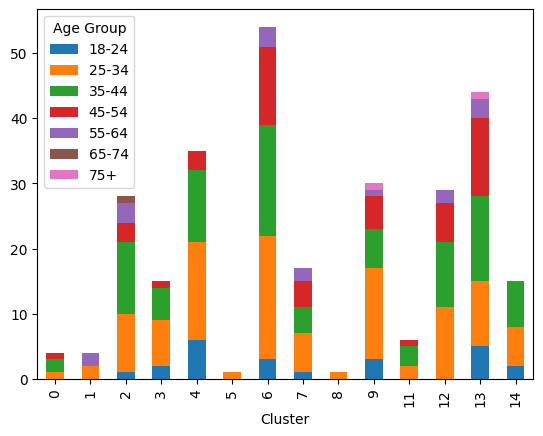

In [48]:
data = pd.DataFrame({'Cluster': clusters, 'Age Group': annotator_df["annotatorAge"]})
grouped_data = data.groupby(['Cluster', 'Age Group']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Cluster', columns='Age Group', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Cluster'>

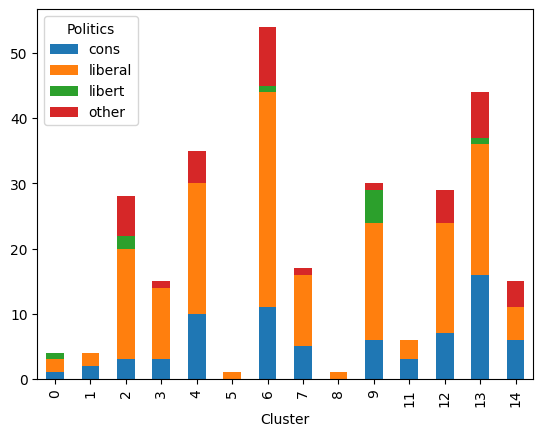

In [49]:
data = pd.DataFrame({'Cluster': clusters, 'Politics': annotator_df["annotatorPolitics"]})
grouped_data = data.groupby(['Cluster', 'Politics']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Cluster', columns='Politics', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Cluster'>

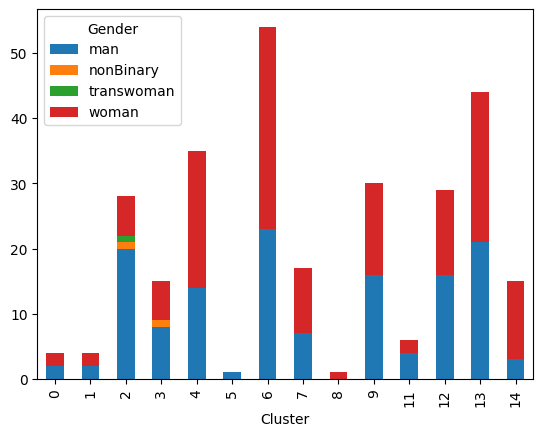

In [50]:
data = pd.DataFrame({'Cluster': clusters, 'Gender': annotator_df["annotatorGender"]})
grouped_data = data.groupby(['Cluster', 'Gender']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Cluster', columns='Gender', values='Count')
pivot_table.plot(kind='bar', stacked=True)

<Axes: xlabel='Cluster'>

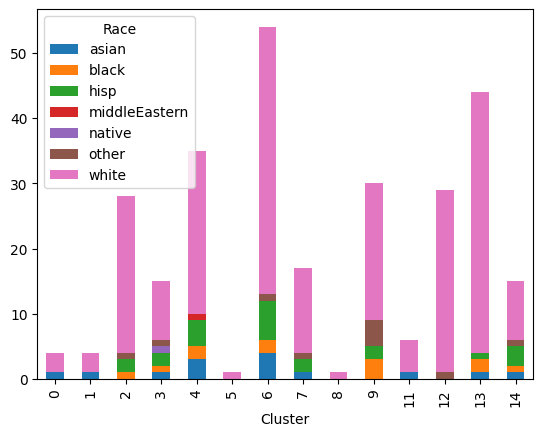

In [51]:
data = pd.DataFrame({'Cluster': clusters, 'Race': annotator_df["annotatorRace"]})
grouped_data = data.groupby(['Cluster', 'Race']).size().reset_index(name='Count')
pivot_table = grouped_data.pivot(index='Cluster', columns='Race', values='Count')
pivot_table.plot(kind='bar', stacked=True)